In [1]:
# Basic imports

import sys

import numpy as np

import xarray as xr

import matplotlib.pyplot as plt

from IPython.display import HTML

import datetime
from cftime import num2date

import cmocean  # for nice oceanographic colourmaps

#JUPYTER notebook magics
%matplotlib inline 

In [2]:
%%bash

# We tune the forcing using these two modules for the atmosphere and ocean boundaries
/home/nextsimdg/build/nextsim --help-config FluxConfiguredAtmosphere
/home/nextsimdg/build/nextsim --help-config FluxConfiguredOcean

FluxConfiguredAtmosphere

FluxConfiguredAtmosphere.Q_ia
numeric    range: -∞—∞  (default = 305.288)
Total ice to atmosphere heat flux (W m⁻²).

FluxConfiguredAtmosphere.dQia_dT
numeric    range: -∞—∞  (default = 4.5036)
Derivative of the ice atmosphere heat flux with respect to temperature (W m⁻² K⁻¹).

FluxConfiguredAtmosphere.Q_ow
numeric    range: -∞—∞  (default = 307.546)
Total open water to atmosphere heat flux (W m⁻²).

FluxConfiguredAtmosphere.sublim
numeric    range: -∞—∞  (default = 0)
Sublimation mass flux from snow to vapour (kg s⁻¹ m⁻²).

FluxConfiguredAtmosphere.snowfall
numeric    range: 0—∞  (default = 0)
Snowfall mass flux (kg s⁻¹ m⁻²).

FluxConfiguredAtmosphere.rainfall
numeric    range: 0—∞  (default = 0)
Rainfall mass flux (kg s⁻¹ m⁻²).

FluxConfiguredAtmosphere.evaporation
numeric    range: 0—∞  (default = 0)
Evaporation mass flux (kg s⁻¹ m⁻²).

FluxConfiguredAtmosphere.wind_u
numeric    range: -∞—∞  (default = 0)
Component of wind in the x (eastward) direction (m s

In [3]:
# Create initial conditions using the make_init_base.py class found in nextsimdg/run

sys.path.append('../../nextsimdg/run')

from make_init_base import initMaker

# Creates initial conditions for the Bjornsson et al. (2001) polynya case

# Domain size [km]
x = 100
y = 50
res = 2

nfirst = int(y / res)
nsecond = int(x / res)
nLayers = 3

# The model expects everything in metres
initializer = initMaker("init_polynya.nc", nfirst, nsecond, nLayers, res*1e3)

# Ice everywhere and all boundaries closed, except the x = 100 km end
initializer.mask[:, :] = 1.
initializer.mask[0, :] = 0.
initializer.mask[-1, :] = 0.
initializer.mask[:, 0] = 0.
#initializer.mask[:, -1] = 0. ## right

# Uniform concentration of 90%
initializer.cice[:, :] = 0.9

# Uniform thickness of 20 cm
initializer.hice[:, :] = 0.2

# Undamaged ice
initializer.damage[:, :] = 1.

# Ice and ocean temperature and salinity at the freezing point
ice_salinity = 5  # should match Ice::s in constants.hpp
mu: float = -0.055  # should match Water::mu in constants.hpp
ocean_temperature = -1.54
ocean_salinity = ocean_temperature / mu

initializer.sss[:, :] = ocean_salinity
initializer.sst[:, :] = ocean_temperature
initializer.tice[:, :, :] = ice_salinity * mu

"""
In a normal script, the file is written when initializer goes out of scope - but in 
Jupyter, we need to call __writeFile__ explicitly
"""
initializer.__writeFile__()

Producing file init_polynya.nc


In [4]:
%%bash

# Run the  model with the polynya config file
time /home/nextsimdg/build/nextsim --config-file config_files/config_polynya.cfg

2023-01-01T00:00:00Z
2023-01-01T00:01:00Z
2023-01-01T00:02:00Z
2023-01-01T00:03:00Z
2023-01-01T00:04:00Z
2023-01-01T00:05:00Z
2023-01-01T00:06:00Z
2023-01-01T00:07:00Z
2023-01-01T00:08:00Z
2023-01-01T00:09:00Z
2023-01-01T00:10:00Z
2023-01-01T00:11:00Z
2023-01-01T00:12:00Z
2023-01-01T00:13:00Z
2023-01-01T00:14:00Z
2023-01-01T00:15:00Z
2023-01-01T00:16:00Z
2023-01-01T00:17:00Z
2023-01-01T00:18:00Z
2023-01-01T00:19:00Z
2023-01-01T00:20:00Z
2023-01-01T00:21:00Z
2023-01-01T00:22:00Z
2023-01-01T00:23:00Z
2023-01-01T00:24:00Z
2023-01-01T00:25:00Z
2023-01-01T00:26:00Z
2023-01-01T00:27:00Z
2023-01-01T00:28:00Z
2023-01-01T00:29:00Z
2023-01-01T00:30:00Z
2023-01-01T00:31:00Z
2023-01-01T00:32:00Z
2023-01-01T00:33:00Z
2023-01-01T00:34:00Z
2023-01-01T00:35:00Z
2023-01-01T00:36:00Z
2023-01-01T00:37:00Z
2023-01-01T00:38:00Z
2023-01-01T00:39:00Z
2023-01-01T00:40:00Z
2023-01-01T00:41:00Z
2023-01-01T00:42:00Z
2023-01-01T00:43:00Z
2023-01-01T00:44:00Z
2023-01-01T00:45:00Z
2023-01-01T00:46:00Z
2023-01-01T00


real	1m25.688s
user	11m8.333s
sys	0m1.693s


In [5]:
# Load the NetCDF file
ds = xr.open_dataset("polynya.diagnostic.nc", group="/data")
print(ds)

# We (still) need to fetch the mask from the init file

mask = xr.open_dataset("init_polynya.nc", group="/data")['mask']
land = np.where(mask == 0, 1, np.nan)  # 1 = land, nan = ocean

<xarray.Dataset>
Dimensions:       (time: 6, ydim: 25, xdim: 50, dg_comp: 6, yvertex: 26,
                   xvertex: 51, ncoords: 2)
Coordinates:
  * time          (time) float64 1.673e+09 1.673e+09 ... 1.673e+09 1.673e+09
Dimensions without coordinates: ydim, xdim, dg_comp, yvertex, xvertex, ncoords
Data variables:
    cice          (time, ydim, xdim, dg_comp) float64 ...
    coords        (yvertex, xvertex, ncoords) float64 ...
    grid_azimuth  (time, ydim, xdim) float64 ...
    hice          (time, ydim, xdim, dg_comp) float64 ...
    u             (time, ydim, xdim) float64 ...
    v             (time, ydim, xdim) float64 ...
    x             (time, ydim, xdim) float64 ...
    y             (time, ydim, xdim) float64 ...


In [6]:
# Create sensible dates to use and a land mask
time = ds['time']
time_vals = num2date(time.values, units='seconds since 1970-01-01', calendar='gregorian')

time_index = 5

In [7]:
# Striding for u and v
ny, nx = ds['u'].isel(time=0).shape
Y, X = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')

stride = 2
u = ds['u'].isel(time=time_index)[::stride, ::stride]
v = ds['v'].isel(time=time_index)[::stride, ::stride]
x = X[::stride, ::stride]
y = Y[::stride, ::stride]

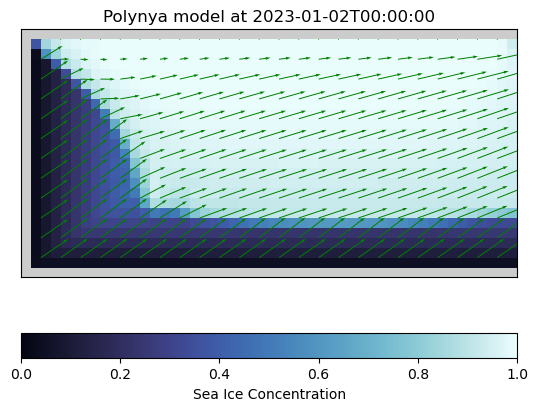

In [8]:
# NB - we need to pick the first DG component, as well as a time slice
var = ds['cice'].isel(time=time_index).isel(dg_comp=0)

plt.figure()
p = plt.pcolormesh(var, shading='auto', cmap='cmo.ice', vmin=0, vmax=1)
plt.gca().set_aspect('equal')

plt.colorbar(p, label='Sea Ice Concentration', orientation='horizontal')

plt.quiver(x, y, u, v, scale=5, color='g', width=0.002)

plt.pcolormesh(land, shading='auto', cmap='Pastel2', vmin=0, vmax=1)

plt.title(f"Polynya model at {time_vals[time_index].isoformat()}")

plt.xticks([])
plt.yticks([])
plt.show()

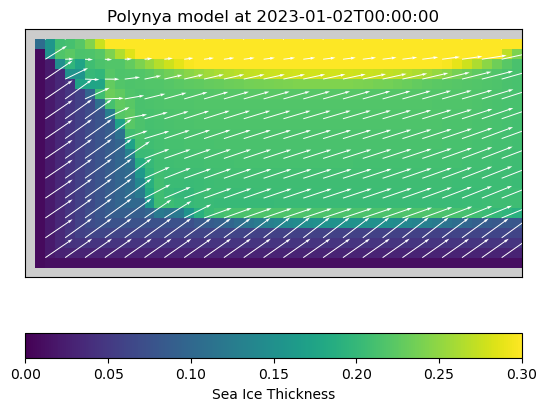

In [9]:
var = ds['hice'].isel(time=time_index).isel(dg_comp=0)

plt.figure()
p = plt.pcolormesh(var, shading='auto', cmap='viridis', vmin=0, vmax=0.3)
plt.gca().set_aspect('equal')

plt.colorbar(p, label='Sea Ice Thickness', orientation='horizontal')

plt.quiver(x, y, u, v, scale=5, color='w', width=0.002)

plt.pcolormesh(land, shading='auto', cmap='Pastel2', vmin=0, vmax=1)

plt.title(f"Polynya model at {time_vals[time_index].isoformat()}")

plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
ds.close()